In [3]:
import numpy as np                    # fast math + arrays
import pandas as pd                   # read CSVs, data tables
import scipy.stats as st             # probability models + .fit()
import matplotlib.pyplot as plt      # plotting
from statsmodels.distributions.empirical_distribution import ECDF  # nonparametric cumulative curve

# --- OPTIONAL PLOT STYLE (makes plots cleaner; OK to skip) -----------------
plt.rcParams.update({
    "axes.spines.top": False,        # cleaner axes
    "axes.spines.right": False,      # cleaner axes
    "axes.grid": True,               # light grid helps read values
    "grid.alpha": 0.25,              # subtle grid
})

In [2]:
def plot_ecdf(data, ax=None, **kw):
    """
    Plot empirical cumulative distribution function (ECDF).
    
    Parameters:
    -----------
    data : array-like
        Input data for ECDF computation
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, uses current axes
    **kw : dict
        Additional keyword arguments passed to ax.step()
    
    Returns:
    --------
    ax : matplotlib.axes.Axes
        The axes object with the plot
    """
    ec = ECDF(data)  # compute ECDF object (x,y steps)
    ax = ax or plt.gca()  # use passed axes OR current axes
    ax.step(ec.x, ec.y, where="post", **kw)
    ax.set_xlabel("Wait (min)")
    ax.set_ylabel("F_hat(x)")  # F-hat = empirical CDF
    return ax


def aic(logL, k):
    """
    Calculate Akaike Information Criterion (AIC).
    
    Parameters:
    -----------
    logL : float
        Log-likelihood value
    k : int
        Number of parameters in the model
    
    Returns:
    --------
    float
        AIC value
    """
    return 2 * k - 2 * logL


def mean_from_params(dist_name, params):
    """
    Calculate mean from distribution parameters.
    
    Parameters:
    -----------
    dist_name : str
        Name of the distribution ('gamma', 'weibull_min', 'lognorm')
    params : tuple
        Parameters of the distribution (shape, loc, scale)
    
    Returns:
    --------
    float
        Mean of the distribution, or np.nan if unknown distribution
    """
    if dist_name == "gamma":
        a, loc, scale = params  # a = shape (k)
        return loc + a * scale  # Gamma mean = loc + k*theta
    
    elif dist_name == "weibull_min":
        c, loc, scale = params  # c = shape
        # Weibull mean uses the gamma function
        return loc + scale * st.gamma(1 + 1/c)
    
    elif dist_name == "lognorm":
        s, loc, scale = params  # s = sigma (log-scale SD); scale = exp(mu)
        # mean = loc + scale * exp(sigma^2 / 
    else:
        return np.nan  # unknown model

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from statsmodels.distributions.empirical_distribution import ECDF

# Read the data
df = pd.read_csv("mbta_wait_times.csv")  # expect columns: period, wait_min

# --- SPLIT INTO PRE / POST -------------------------------------------------
pre = df.loc[df.period == "PRE", "wait_min"].to_numpy()
post = df.loc[df.period == "POST", "wait_min"].to_numpy()

# --- QUICK SUMMARY ---------------------------------------------------------
print(f"PRE n={pre.size}, mean={pre.mean():.2f} min")
print(f"POST n={post.size}, mean={post.mean():.2f} min")

# Optional: Check the data structure
print(f"\nDataFrame shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Period values: {df.period.unique()}")

PRE n=600, mean=3.85 min
POST n=650, mean=4.84 min

DataFrame shape: (1250, 2)
Columns: ['period', 'wait_min']
Period values: ['PRE' 'POST']


Q1.1. How many total waits were recorded in each period?

PRE period: 600 waits
POST period: 650 waits
Total: 1,250 waits

Q1.2. What are the raw sample means?

PRE period: 3.85 minutes
POST period: 4.84 minutes



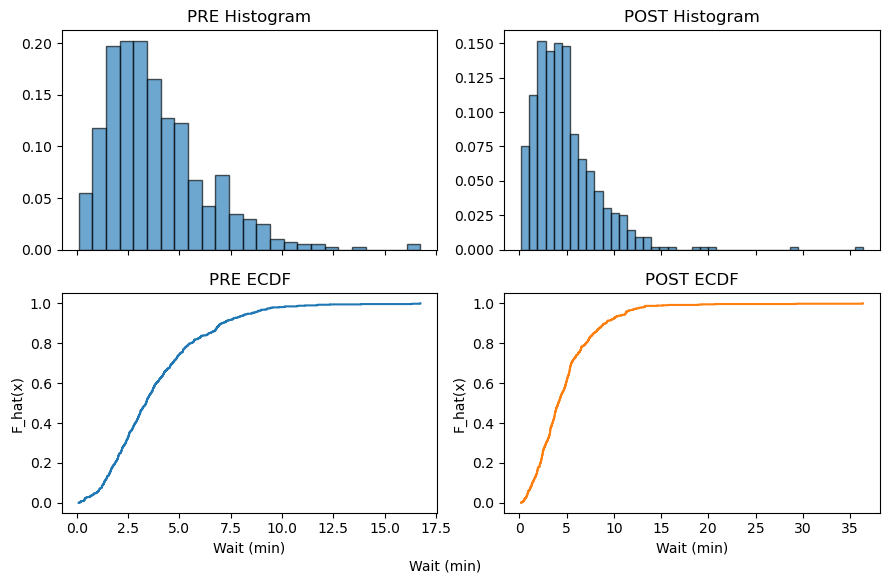

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6), sharex='col')

# TOP ROW: HISTOGRAMS show approximate density
axs[0, 0].hist(pre, bins="auto", density=True, alpha=0.65, edgecolor="k")
axs[0, 0].set_title("PRE Histogram")

axs[0, 1].hist(post, bins="auto", density=True, alpha=0.65, edgecolor="k")
axs[0, 1].set_title("POST Histogram")

# BOTTOM ROW: ECDFs show cumulative % of waits <= x
plot_ecdf(pre, ax=axs[1, 0], color="C0")
axs[1, 0].set_title("PRE ECDF")

plot_ecdf(post, ax=axs[1, 1], color="C1")
axs[1, 1].set_title("POST ECDF")

# Add shared x-axis label
fig.text(0.5, 0.04, "Wait (min)", ha="center")
fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()

Q2.1. Compare PRE vs POST shapes: Which is more spread out? More right-skewed?
POST is more spread out. The ECDF and histogram for POST show a wider range of values, with wait times extending past 35 minutes.

Q2.2. Do you see extreme long waits (outliers) by eye? Which period shows them? Leave them
in the data set for now, but calculate any outliers by looking at 1.5 +/- the IQR of your data and
print them out in a cell.
Yes, in the POST period. The ECDF flattens at high values. 

In [23]:

pre_waits = df[df['period'] == 'PRE']['wait_min']
post_waits = df[df['period'] == 'POST']['wait_min']

def find_outliers(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers, lower_bound, upper_bound

pre_outliers, pre_lb, pre_ub = find_outliers(pre_waits)
post_outliers, post_lb, post_ub = find_outliers(post_waits)

print(f"{pre_lb:.2f} {pre_ub:.2f}")
print(f"{len(pre_outliers)}")
print(sorted(pre_outliers.tolist()))


print(f"{post_lb:.2f} {post_ub:.2f}")
print(f" {len(post_outliers)}")
print(sorted(post_outliers.tolist()))


-2.25 9.42
15
[9.422282193191313, 9.450312777673624, 9.53380559359136, 9.853289622499425, 10.103327683786627, 10.140301361924095, 10.729393331843577, 10.779048035513943, 11.120463173855216, 11.696088188412755, 11.739244918496466, 12.329866645380712, 13.875048039255976, 16.31647512129235, 16.747253791076403]
-3.15 11.85
 22
[11.92570392589819, 12.05688731855984, 12.078431555310903, 12.140880770204369, 12.326314094483868, 12.392507216416744, 12.65177186074435, 12.667229050276362, 12.86828829909019, 13.151101395124812, 13.232650072889092, 13.251082436656368, 13.287068768093212, 13.371061233084175, 14.559791100783404, 15.171682174238727, 15.7396979166761, 18.90672242169352, 19.247471907444726, 20.70682148802069, 29.27458640814392, 36.35593593096405]


In [7]:
# --- YOUR MODEL SHORTLIST --------------------------------------------------
candidates = {
"gamma": st.gamma,
"weibull_min": st.weibull_min, # swap/add "lognorm": st.lognorm if you like
}
print("Candidate models:", list(candidates))

Candidate models: ['gamma', 'weibull_min']




Q3.1. Below is a sample of a model ”shortlist,” where it is the different models you want to
compare. Feel free to try out other distributions such as lognormal. After picking distributions,
record your reasons (“We picked Gamma because...”)
We picked Gamma and Lognormal because our data is right-skewed and not negative, and these distributions handle that well. They handle it better than exponential. 

Q3.2. Your friend said that we should use normal distributions for this because everything
is a normal distribution if you you have enough arrival times. Explain to him below 1) why you
don’t want to use a normal distribution, and 2) why he is incorrect that if we kept recording more
arrival times that it would not become normally distributed (hint: the central limit theorem is a
mathematical statement about what kind of mean and are arrival times that mean?).
Your friend is wrong because the Central Limit Theorem only says that the mean of many samples becomes normal, not the original raw data itself.


In [24]:
def aic(logL, k):
    return 2 * k - 2 * logL

def fit_models(data, models):
    """
    Fit each SciPy distribution in 'models' to 1-D numpy array 'data'.
    Returns a DataFrame (rows = models, columns = params/logL/k/AIC) sorted by AIC.
    """
    out = {}
    for name, dist in models.items():
        params = dist.fit(data)  # MLE: find params that max log-likelihood
        logL = dist.logpdf(data, *params).sum()  # total log-likelihood at those params
        k = len(params)  # number of fitted parameters
        out[name] = dict(params=params, logL=logL, k=k, AIC=aic(logL, k))
    
    return pd.DataFrame(out).T.sort_values("AIC")  # lower AIC = better

fit_pre = fit_models(pre, candidates)
fit_post = fit_models(post, candidates)

print("PRE best model:", fit_pre.index[0], f"(AIC = {fit_pre.iloc[0]['AIC']:.2f})")
print("POST best model:", fit_post.index[0], f"(AIC = {fit_post.iloc[0]['AIC']:.2f})")

print("PRE fits:")
display(fit_pre)

print("POST fits:")
display(fit_post)

PRE best model: gamma (AIC = 2600.90)
POST best model: gamma (AIC = 3163.65)
PRE fits:


,params,logL,k,AIC
gamma,"(2.8330720359523776, -0.17588555964314997, 1.4...",-1297.451464,3,2600.902927
weibull_min,"(1.4548509669295906, 0.5989530214768142, 3.650...",-inf,3,inf


POST fits:


,params,logL,k,AIC
gamma,"(2.102145720176475, 0.08445217003943417, 2.262...",-1578.8265,3,3163.653
weibull_min,"(1.1796449365987804, 0.1889757828003762, 3.582...",-1653.884507,3,3313.769013


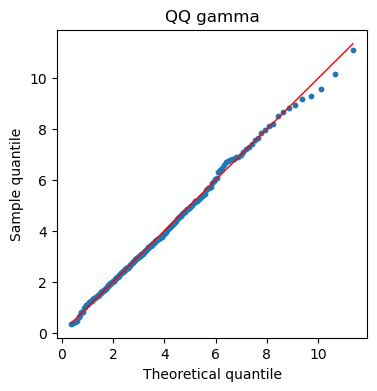

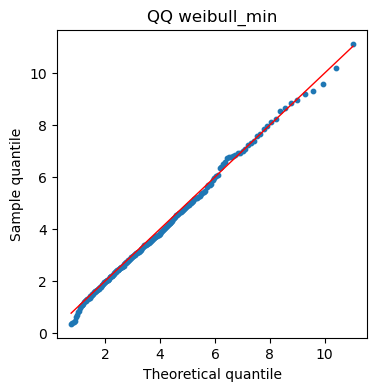

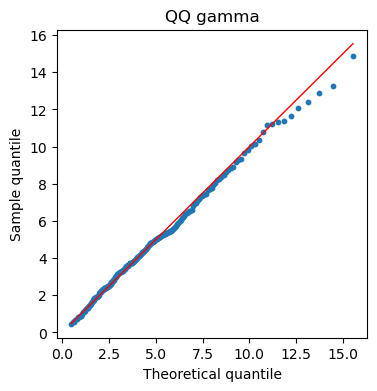

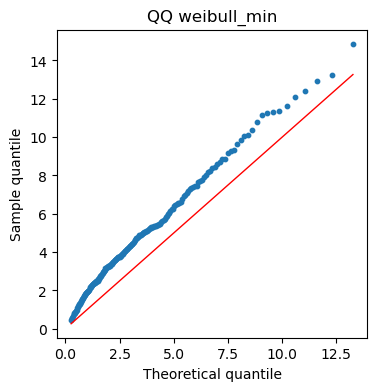

In [12]:
def qq_compare(data, fit_tbl, models, probs=np.linspace(0.01, 0.99, 200)):
    """
    Make QQ plots for each fitted model in fit_tbl.
    'probs' are the quantile levels (0-1) we compare.
    """
    qs = np.quantile(data, probs)  # sample quantiles from data
    
    for name in fit_tbl.index:  # models in AIC order
        dist = models[name]
        params = fit_tbl.loc[name, "params"]
        qt = dist.ppf(probs, *params)  # theoretical quantiles from model
        
        plt.figure(figsize=(4, 4))
        plt.scatter(qt, qs, s=10)
        plt.plot(qt, qt, 'r', lw=1)  # 45 degree reference line
        plt.title(f"QQ {name}")
        plt.xlabel("Theoretical quantile")
        plt.ylabel("Sample quantile")
        plt.show()


# --- MAKE QQ PLOTS ---------------------------------------------------------
qq_compare(pre, fit_pre, candidates)
qq_compare(post, fit_post, candidates)

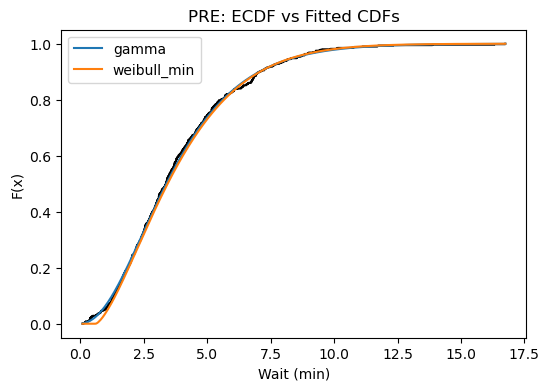

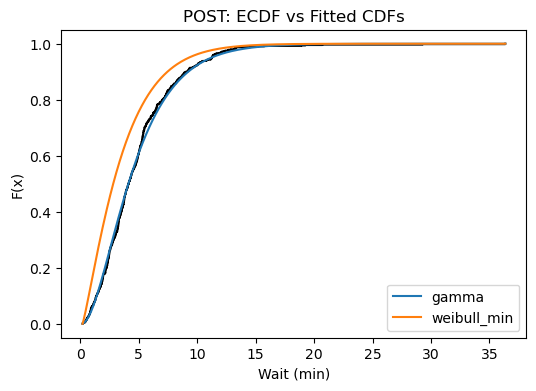

In [14]:
def cdf_overlay(data, fit_tbl, models, title):
    """
    ECDF (black steps) + each fitted model's CDF (smooth lines).
    """
    plt.figure(figsize=(6, 4))
    plot_ecdf(data, color="k")
    
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name, "params"]
        plt.plot(xx, dist.cdf(xx, *pars), label=name)
    
    plt.legend()
    plt.title(title)
    plt.xlabel("Wait (min)")
    plt.ylabel("F(x)")
    plt.show()


# --- MAKE CDF OVERLAYS -----------------------------------------------------
cdf_overlay(pre, fit_pre, candidates, title="PRE: ECDF vs Fitted CDFs")
cdf_overlay(post, fit_post, candidates, title="POST: ECDF vs Fitted CDFs")

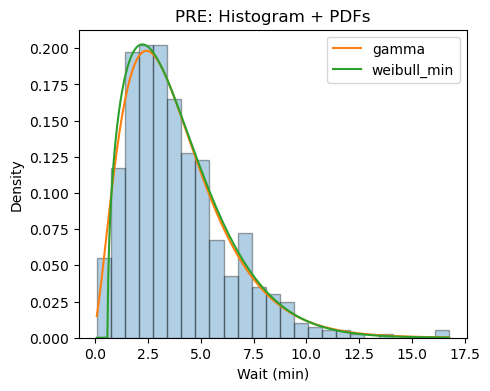

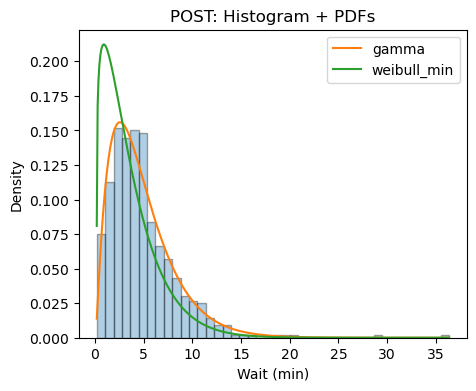

In [18]:
def pdf_overlay(data, fit_tbl, models, title):
    """
    Histogram (bars) + each fitted model's PDF (smooth lines).
    """
    plt.figure(figsize=(5, 4))
    plt.hist(data, bins="auto", density=True, alpha=0.35, edgecolor="k")
    
    xx = np.linspace(data.min(), data.max(), 400)
    for name in fit_tbl.index:
        dist = models[name]
        pars = fit_tbl.loc[name, "params"]
        plt.plot(xx, dist.pdf(xx, *pars), label=name)
    
    plt.legend()
    plt.title(title)
    plt.xlabel("Wait (min)")
    plt.ylabel("Density")
    plt.show()


# --- MAKE PDF OVERLAYS -----------------------------------------------------
pdf_overlay(pre, fit_pre, candidates, "PRE: Histogram + PDFs")
pdf_overlay(post, fit_post, candidates, "POST: Histogram + PDFs")

Q5.1 - The POST Model Struggles the most.


Q 5.2 - No it does not visibly pull any model curves

In [21]:
# --- PICK BEST MODELS BY AIC -----------------------
best_pre = fit_pre.index[0]
best_post = fit_post.index[0]
# --- GET MEANS FROM FITTED PARAMS ------------------------------------------
mu_pre = mean_from_params(best_pre, fit_pre.loc[best_pre,"params"])
mu_post = mean_from_params(best_post, fit_post.loc[best_post,"params"])
# --- PRACTICAL CHANGE -------------------------------------------------------
delta = mu_post - mu_pre
ratio = mu_post / mu_pre
print(f"Best PRE model: {best_pre} mean{mu_pre:.2f} min")
print(f"Best POST model: {best_post} mean{mu_post:.2f} min")
print(f"Change POST-PRE: {delta:+.2f} min ({ratio:.2f})")

Best PRE model: gamma mean3.85 min
Best POST model: gamma mean4.84 min
Change POST-PRE: +0.99 min (1.26)


Q6.2. Decide: Is that difference practically important?
After construction, typical waits are about 0.99 minutes (or about 1 minute) longer.


Q6.2. Decide: Is that difference practically important?
Yes, this is practically important because the increase is almost 1 minute, which is almost a 30% increase in wait time. That is significant and can cause a difference in daily routine. 


Q6.3. If two models had ∆AIC < 2, does this imply the result is more or less robust?
Less robust, because it means we have more uncertainty and that multiple models are equivalent in explaining data.


